In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from scipy import integrate
from numba import njit

## Distribución exponencial

Vamos a tomar núcleos de Bi 212 con $$T_{1/2}=60.55 \ \mathrm{min}$$ ahora al calcular el $\tau$ y $\Gamma$

In [14]:
tau=60.55/np.log(2)
gamma=1/tau
print(f"gamma = {gamma}")


gamma = 0.011447517432864497


La probabilidad de decaer de un núcleo por minuto es de 0.011, por lo que vamos a considerar un $\Delta t$ de 5 minutos y tomando un rango de tiempo desde $t=0$ hasta $t_{f}=20\tau$

In [15]:
t=np.arange(0,20*tau+1,5)
tmed=((t+np.roll(t, shift=1))/2)[1:]

def P(t):
    return gamma*np.exp(-gamma*t)

pdf=np.array([integrate.quad(P,i,i+5)[0] for i in t[:-1]]) #integramos en el dt para obtener la pdf en el tiempo

cdf=np.cumsum(pdf) 
cdf=np.insert(cdf, 0, 0)#encontramos la cdf



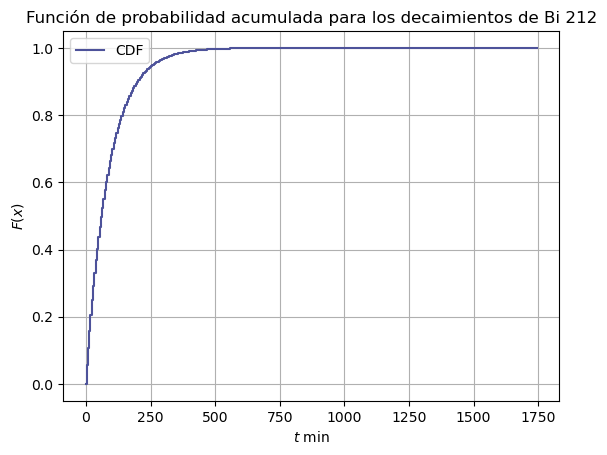

In [16]:
plt.plot(t,cdf, ds="steps-mid", color="#4D529A", label=("CDF"))

plt.title("Función de probabilidad acumulada para los decaimientos de Bi 212")
plt.ylabel(r"$F(x)$")
plt.xlabel(r"$t$ min")
plt.grid()
plt.legend()
plt.show()



Ya con la cdf vamos a simular los decaimientos

In [17]:
rn.seed(62)
#Función para simular decaimientos de N núcleos
@njit
def simul(N):
    histograma=np.zeros(N)
    for i in range(N):
        r = rn.random()
        if r <= cdf.max():
            for j in np.arange(1,len(cdf)):
                if r >= cdf[j-1] and r < cdf[j]:             
                    histograma[i]=tmed[j-1]
                    break
        else:
            continue
    no_cero = np.nonzero(histograma)
    histograma=histograma[no_cero] #los valores que quedan 0 son para aquellos nucleos que decaen después de 4 tau
    return histograma       #retorna lista con el minuto en que decayó cada núcleo

N=np.array([1e2,1e3,1e6,1e8])
s=[]
for n in N:
    s.append(simul(int(n)))   #simulamos para las diferentes cantidades de núcleos

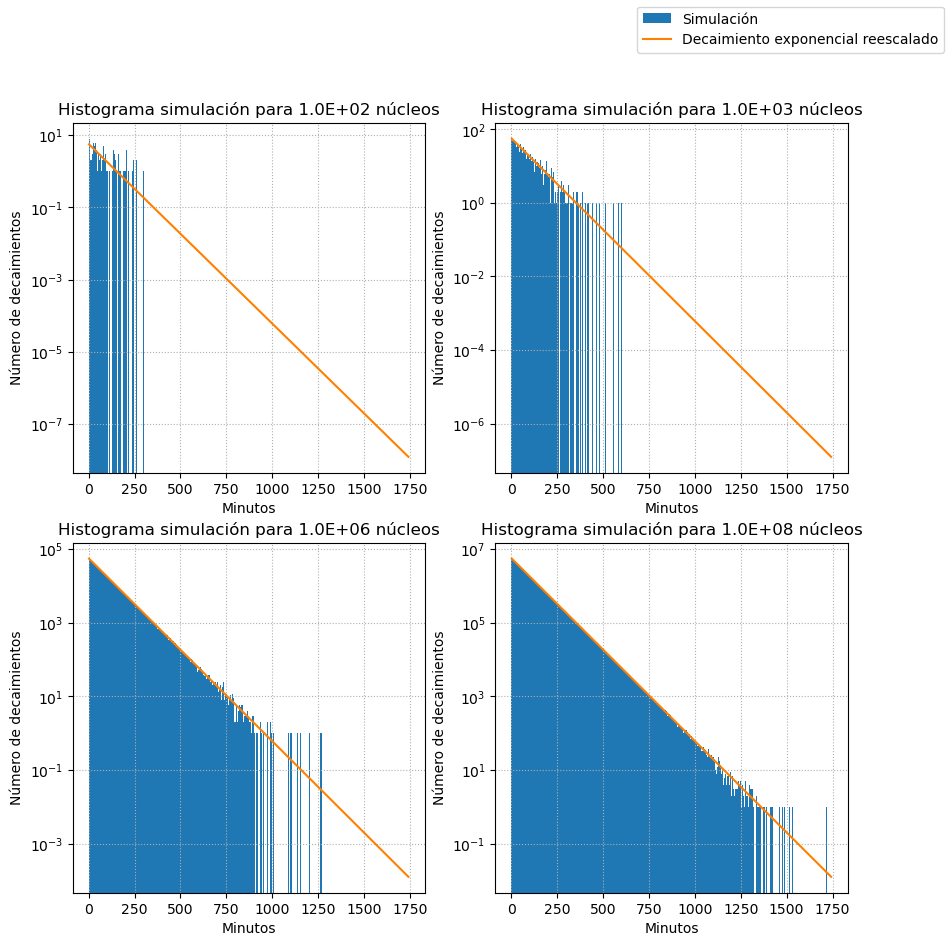

In [18]:
fig , ax = plt.subplots(2,2,figsize=(10,10))  #Graficacion

ax[0,0].hist(s[0],t,label=("Simulación"))
ax[0,0].plot(tmed,N[0]*pdf, color="#ff8000", label=("Decaimiento exponencial reescalado")) #Se multiplica por N la pdf para comparar con el histograma
ax[0,0].set_title(f"Histograma simulación para {N[0]:.1E} núcleos")
ax[0,0].set_ylabel("Número de decaimientos")
ax[0,0].set_xlabel("Minutos")
ax[0,0].set_yscale("log")
ax[0,0].grid(linestyle=':')

ax[0,1].hist(s[1],t)
ax[0,1].plot(tmed,N[1]*pdf , color="#ff8000") #Se multiplica por N la pdf para comparar con el histograma
ax[0,1].set_title(f"Histograma simulación para {N[1]:.1E} núcleos")
ax[0,1].set_ylabel("Número de decaimientos")
ax[0,1].set_xlabel("Minutos")
ax[0,1].set_yscale("log")
ax[0,1].grid(linestyle=':')

ax[1,0].hist(s[2],t)
ax[1,0].plot(tmed,N[2]*pdf , color="#ff8000") #Se multiplica por N la pdf para comparar con el histograma
ax[1,0].set_title(f"Histograma simulación para {N[2]:.1E} núcleos")
ax[1,0].set_ylabel("Número de decaimientos")
ax[1,0].set_xlabel("Minutos")
ax[1,0].set_yscale("log")
ax[1,0].grid(linestyle=':')

ax[1,1].hist(s[3],t)
ax[1,1].plot(tmed,N[3]*pdf , color="#ff8000") #Se multiplica por N la pdf para comparar con el histograma
ax[1,1].set_title(f"Histograma simulación para {N[3]:.1E} núcleos")
ax[1,1].set_ylabel("Número de decaimientos")
ax[1,1].set_xlabel("Minutos")
ax[1,1].set_yscale("log")
ax[1,1].grid(linestyle=':')

fig.legend()
plt.show()


# Distribución binomial


la probabilidad de que el nucleo decaiga en un intervalo de tiempo $\Delta t$ de 5 min estará dado por

$$ \int_{0}^{5}P(t)dt=\int_{0}^{5} \Gamma e^{-\Gamma t}\simeq 0.0556
$$

El valor exacto de p es:


In [19]:
pdf[0]

0.05563032740190176

Por lo que la cdf de esta distribución binomial será

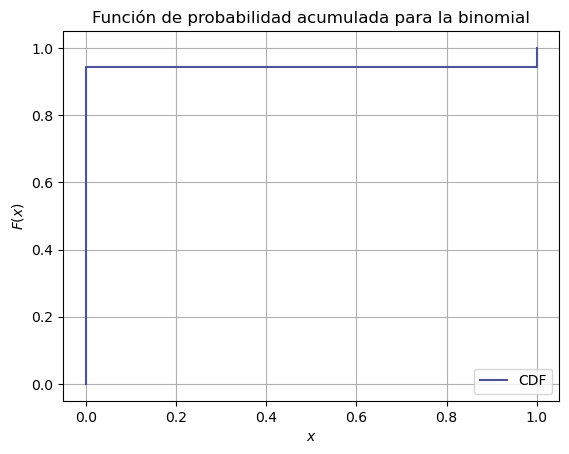

In [20]:
pdf2=np.array([0,1-pdf[0],pdf[0]])
cdf2=np.cumsum(pdf2)
x=np.array([0,0,1])
plt.plot(x,cdf2,ds="steps-post" ,color="#4D529A", label=("CDF"))
plt.title("Función de probabilidad acumulada para la binomial")
plt.ylabel(r"$F(x)$")
plt.xlabel(r"$x$")
plt.grid()
plt.legend(loc=4)
plt.show()


In [21]:
@njit
def simul2(N):
    numero_nucleos=N
    N_t=[]
    tiempos=[]
    ti=0
    dec=0
    while numero_nucleos > 0:
        N_t.append(numero_nucleos)
        for n in range(0,numero_nucleos):
            r=rn.random()
            if r < pdf[0]:
                dec+=1    
        tiempos.append(ti)
        ti+=5
        numero_nucleos-=dec
        dec=0
    return np.array([tiempos,N_t])

N=np.array([1e2,1e3,1e6,1e8])
s2=[]
for n in N:
    s2.append(simul2(int(n)))   #simulamos para las diferentes cantidades de núcleos



In [22]:
#para encontrar la cantidad de nucleos en la simulacion exponencial, teniendo el número de decaimientos hacemos lo siguiente
s_1=[]
j=0
for i in s:
    s_1.append(np.histogram(s[j],t)[1])
    n_nucleos=np.histogram(s[j],t)[0]
    s_1.append(N[j]-np.cumsum(np.insert(n_nucleos,0,1)))
    j+=1


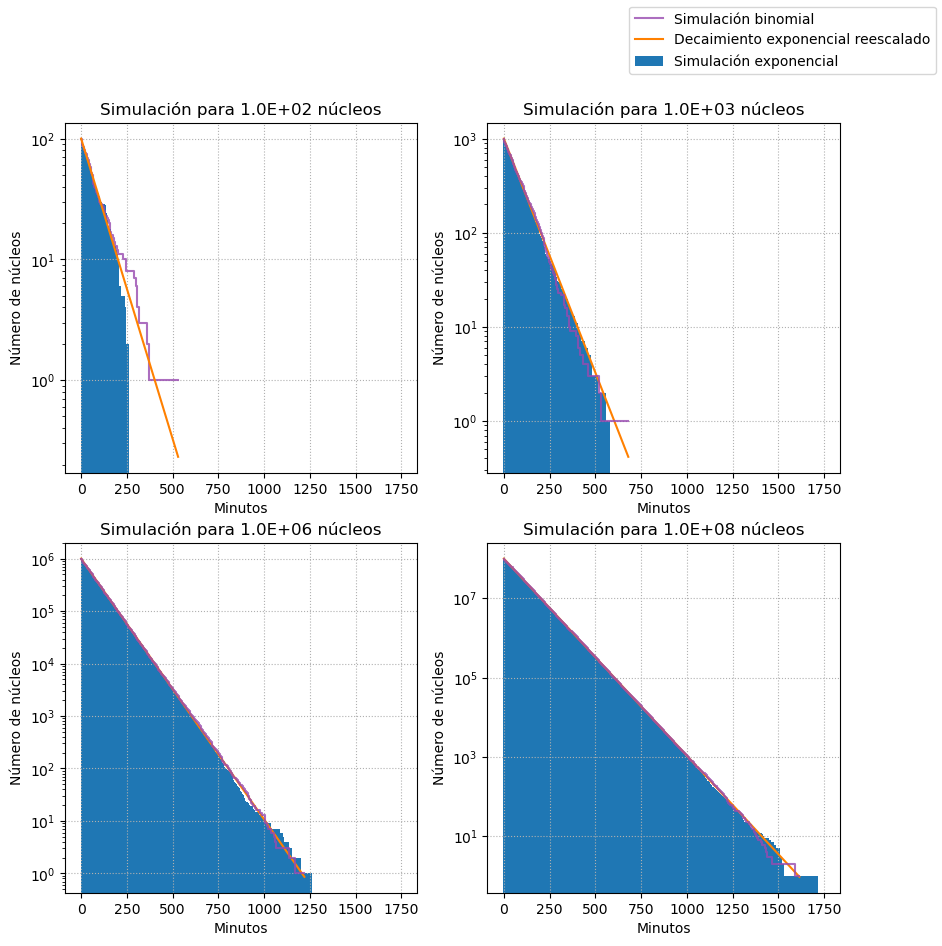

In [23]:
fig , ax = plt.subplots(2,2,figsize=(10,10))  #Graficacion


ax[0,0].bar(s_1[0],s_1[1],width=5,label=("Simulación exponencial"))
ax[0,0].plot(s2[0][0],s2[0][1],color="#984AB0",label=("Simulación binomial"),alpha=0.8,ds="steps-mid") 
ax[0,0].plot(s2[0][0],np.exp(-gamma*s2[0][0])*N[0], color="#ff8000", label=("Decaimiento exponencial reescalado"))   
ax[0,0].set_title(f"Simulación para {N[0]:.1E} núcleos")
ax[0,0].set_ylabel("Número de núcleos")
ax[0,0].set_xlabel("Minutos")
ax[0,0].set_yscale("log")
ax[0,0].grid(linestyle=':')
 

ax[0,1].bar(s_1[2],s_1[3],width=5)
ax[0,1].plot(s2[1][0],np.exp(-gamma*s2[1][0])*N[1], color="#ff8000") 
ax[0,1].plot(s2[1][0],s2[1][1],color="#984AB0",alpha=0.8,ds="steps-mid")   
ax[0,1].set_title(f"Simulación para {N[1]:.1E} núcleos")
ax[0,1].set_ylabel("Número de núcleos")
ax[0,1].set_xlabel("Minutos")
ax[0,1].set_yscale("log")
ax[0,1].grid(linestyle=':')

ax[1,0].bar(s_1[4],s_1[5],width=5)
ax[1,0].plot(s2[2][0],np.exp(-gamma*s2[2][0])*N[2], color="#ff8000") 
ax[1,0].plot(s2[2][0],s2[2][1],color="#984AB0",alpha=0.8,ds="steps-mid")   
ax[1,0].set_title(f"Simulación para {N[2]:.1E} núcleos")
ax[1,0].set_ylabel("Número de núcleos")
ax[1,0].set_xlabel("Minutos")
ax[1,0].set_yscale("log")
ax[1,0].grid(linestyle=':')

ax[1,1].bar(s_1[6],s_1[7],width=5)
ax[1,1].plot(s2[3][0],np.exp(-gamma*s2[3][0])*N[3], color="#ff8000")  
ax[1,1].plot(s2[3][0],s2[3][1],color="#984AB0",alpha=0.8,ds="steps-mid")   
ax[1,1].set_title(f"Simulación para {N[3]:.1E} núcleos")
ax[1,1].set_ylabel("Número de núcleos")
ax[1,1].set_xlabel("Minutos")
ax[1,1].set_yscale("log")
ax[1,1].grid(linestyle=':')

fig.legend()
plt.show()